In [40]:
import pandas as pd
import matplotlib.pyplot as plt
import optuna
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score

import numpy as np
import time

import psutil
import subprocess

In [41]:
start_time = time.time()

In [42]:
# Load dataset
df = pd.read_csv("pdc_dataset_with_target.csv")

num_duplicates = df.duplicated().sum()
filtered_df_no_duplicates = df.drop_duplicates()
rows_removed_due_to_duplicates = df.shape[0] - filtered_df_no_duplicates.shape[0]
df = filtered_df_no_duplicates
filtered_df_no_duplicates.shape[0], rows_removed_due_to_duplicates

(40045, 955)

In [43]:
df.isnull().sum()
df = df.dropna()
df.isnull().sum()

feature_1    0
feature_2    0
feature_3    0
feature_4    0
feature_5    0
feature_6    0
feature_7    0
target       0
dtype: int64

In [44]:
# Column definitions
numerical_cols = ['feature_1', 'feature_2', 'feature_4', 'feature_6','feature_7']
categorical_cols = ['feature_3', 'feature_5']

In [45]:
def remove_outliers_iqr(df, cols):
    filtered_df = df.copy()
    for col in cols:
        Q1 = filtered_df[col].quantile(0.25)
        Q3 = filtered_df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        filtered_df = filtered_df[(filtered_df[col] >= lower_bound) & (filtered_df[col] <= upper_bound)]
    return filtered_df

df = remove_outliers_iqr(df, numerical_cols)



In [46]:
X = df.drop('target', axis=1)
y = df['target']

# Column definitions
numerical_cols = ['feature_1', 'feature_2', 'feature_4', 'feature_7']
categorical_cols = ['feature_3', 'feature_5']

# Preprocessing pipelines
numerical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])
categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])
preprocessor = ColumnTransformer([
    ('num', numerical_pipeline, numerical_cols),
    ('cat', categorical_pipeline, categorical_cols)
])

# Apply preprocessing once
X_processed = preprocessor.fit_transform(X)

# Split
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42)


In [47]:
end_time = time.time()
print(f"Total execution time: {end_time - start_time:.2f} seconds")

Total execution time: 0.26 seconds


In [48]:
# Logging setup
resource_logs = {
    'cpu': [],
    'mem': [],
    'threads': [],
    'time': []
}

def log_resources():
    cpu = psutil.cpu_percent(interval=1)
    mem = psutil.virtual_memory().percent
    threads = psutil.Process().num_threads()
    resource_logs['cpu'].append(cpu)
    resource_logs['mem'].append(mem)
    resource_logs['threads'].append(threads)


In [49]:
# Define Optuna objective
def objective(trial):
    params = {
        'eval_metric': 'logloss',
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0)
    }
    
    model = xgb.XGBClassifier(n_jobs=1, **params)
    model.fit(X_train, y_train)
    
    log_resources()  # Log after training
    elapsed_time = time.time() - start_time
    resource_logs['time'].append(elapsed_time)
    
    preds = model.predict(X_test)
    probas = model.predict_proba(X_test)[:, 1]
    
    acc = accuracy_score(y_test, preds)
    auc = roc_auc_score(y_test, probas)
    cm = confusion_matrix(y_test, preds)
    report = classification_report(y_test, preds, output_dict=True)
    
    # Store additional metrics in the trial
    trial.set_user_attr("roc_auc", auc)
    trial.set_user_attr("confusion_matrix", cm.tolist())
    trial.set_user_attr("classification_report", report)
    
    return acc

# Run Optuna study
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=500)

print("Best Params:", study.best_params)
best_trial = study.best_trial

print("Best Accuracy:", best_trial.value)
print("ROC AUC:", best_trial.user_attrs["roc_auc"])
print("Confusion Matrix:", best_trial.user_attrs["confusion_matrix"])
print("Classification Report:")
from pprint import pprint
pprint(best_trial.user_attrs["classification_report"])

[I 2025-05-04 22:30:21,724] A new study created in memory with name: no-name-e016bacb-9a6e-4234-907d-d75d4267a60c
[I 2025-05-04 22:30:23,561] Trial 0 finished with value: 0.5591451292246521 and parameters: {'max_depth': 9, 'learning_rate': 0.1339333280986961, 'n_estimators': 131, 'subsample': 0.9253406613555214, 'colsample_bytree': 0.6332499540013271}. Best is trial 0 with value: 0.5591451292246521.
[I 2025-05-04 22:30:25,628] Trial 1 finished with value: 0.56610337972167 and parameters: {'max_depth': 4, 'learning_rate': 0.18648806036824664, 'n_estimators': 329, 'subsample': 0.62628185332631, 'colsample_bytree': 0.9220080588390008}. Best is trial 1 with value: 0.56610337972167.
[I 2025-05-04 22:30:32,050] Trial 2 finished with value: 0.5415838303512259 and parameters: {'max_depth': 8, 'learning_rate': 0.1308841331757373, 'n_estimators': 470, 'subsample': 0.7406276927349351, 'colsample_bytree': 0.991544421285341}. Best is trial 1 with value: 0.56610337972167.
[I 2025-05-04 22:30:39,020]

Best Params: {'max_depth': 3, 'learning_rate': 0.02441161582166702, 'n_estimators': 183, 'subsample': 0.8905530874698425, 'colsample_bytree': 0.8153742009939136}
Best Accuracy: 0.6033797216699801
ROC AUC: 0.5089472352120445
Confusion Matrix: [[3638, 0], [2394, 4]]
Classification Report:
{'0': {'f1-score': 0.752430196483971,
       'precision': 0.6031167108753316,
       'recall': 1.0,
       'support': 3638.0},
 '1': {'f1-score': 0.0033305578684429643,
       'precision': 1.0,
       'recall': 0.0016680567139282735,
       'support': 2398.0},
 'accuracy': 0.6033797216699801,
 'macro avg': {'f1-score': 0.377880377176207,
               'precision': 0.8015583554376657,
               'recall': 0.5008340283569641,
               'support': 6036.0},
 'weighted avg': {'f1-score': 0.4548256680876761,
                  'precision': 0.7607916822671399,
                  'recall': 0.6033797216699801,
                  'support': 6036.0}}


In [50]:
end_time = time.time()
print(f"Total execution time: {end_time - start_time:.2f} seconds")

Total execution time: 1540.51 seconds


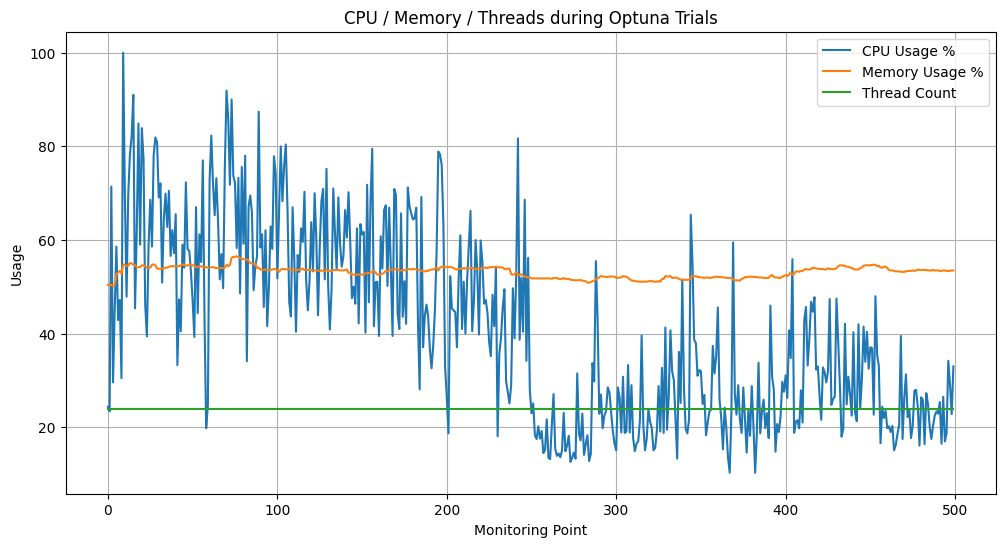

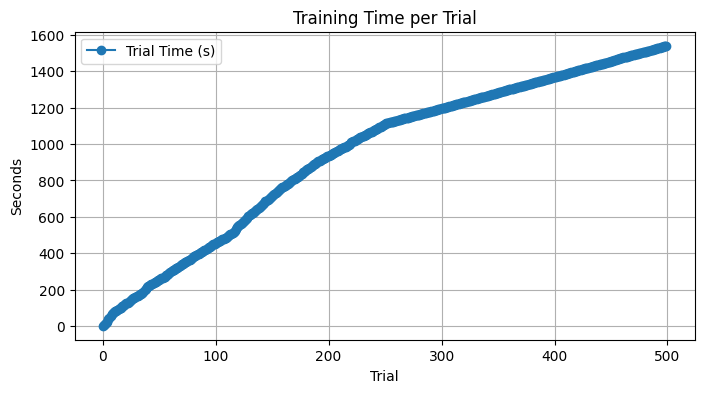

In [51]:
epochs = list(range(len(resource_logs['cpu'])))

plt.figure(figsize=(12, 6))
plt.plot(epochs, resource_logs['cpu'], label='CPU Usage %')
plt.plot(epochs, resource_logs['mem'], label='Memory Usage %')
plt.plot(epochs, resource_logs['threads'], label='Thread Count')
plt.xlabel("Monitoring Point")
plt.ylabel("Usage")
plt.title("CPU / Memory / Threads during Optuna Trials")
plt.legend()
plt.grid(True)
plt.show()

# Time per trial
plt.figure(figsize=(8, 4))
plt.plot(range(len(resource_logs['time'])), resource_logs['time'], marker='o', label='Trial Time (s)')
plt.xlabel("Trial")
plt.ylabel("Seconds")
plt.title("Training Time per Trial")
plt.legend()
plt.grid(True)
plt.show()
